## Autoencoders and Denoising Autoencoders

In [2]:
## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image
from keras import datasets

from keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt
plt.gray()

Using TensorFlow backend.


## Data loading

In [3]:
## Download the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 2s 0us/step


In [4]:
## normalize and reshape
x_train = x_train/255.
x_test = x_test/255.

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [5]:
x_train.shape

(60000, 28, 28, 1)

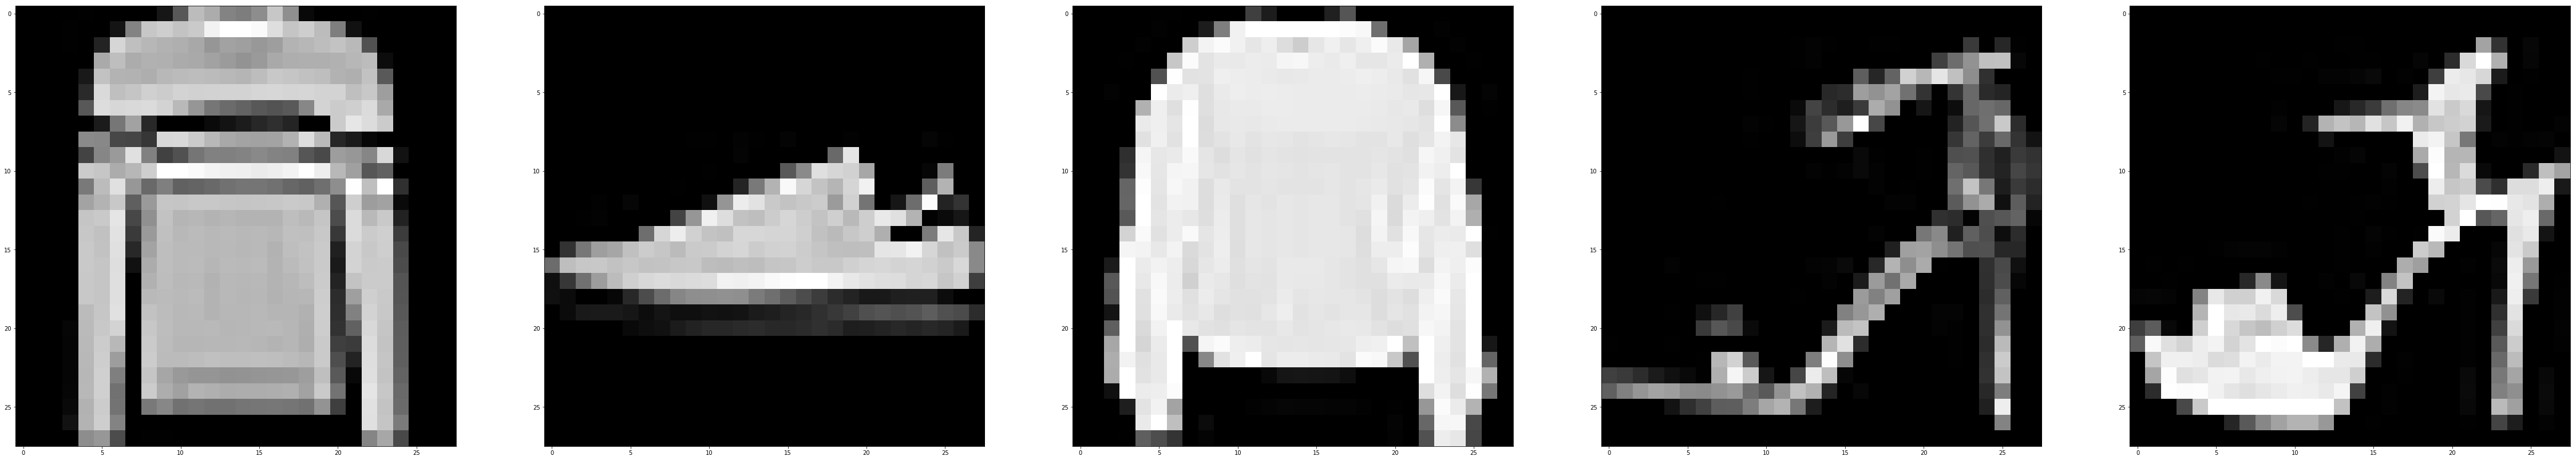

In [6]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(x_train[i, :, :, 0].reshape(28, 28))

## Part 2: Denoise Images using AEs

In [16]:
![Autoencoders](https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png)

/bin/sh: 1: Syntax error: word unexpected (expecting ")")


In [7]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(x_train * 255) / 255
val_x_n = seq_object.augment_images(x_test * 255) / 255

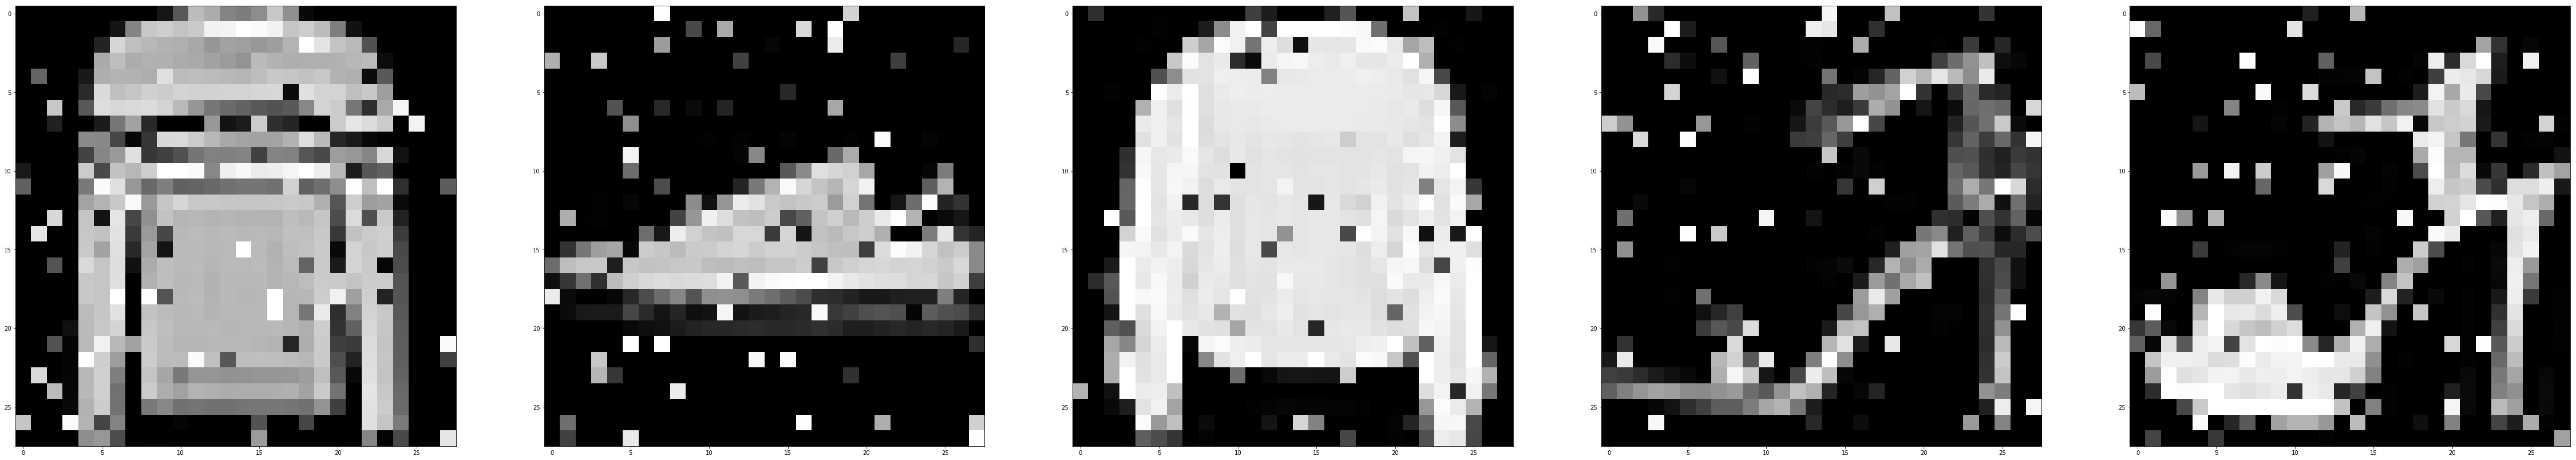

In [8]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i, :, :, 0].reshape(28, 28))

### Design the network

In [9]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

In [10]:
# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

In [11]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
__________

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(train_x_n, x_train, epochs=20, batch_size=2048, validation_data=(val_x_n, x_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0906 - val_loss: 0.0529
Epoch 2/20
60000/60000 [==============================] - 150s 2ms/step - loss: 0.0438 - val_loss: 0.0361
Epoch 3/20
60000/60000 [==============================] - 150s 2ms/step - loss: 0.0326 - val_loss: 0.0290
Epoch 4/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0270 - val_loss: 0.0252
Epoch 5/20
60000/60000 [==============================] - 149s 2ms/step - loss: 0.0241 - val_loss: 0.0233
Epoch 6/20
60000/60000 [==============================] - 149s 2ms/step - loss: 0.0223 - val_loss: 0.0215
Epoch 7/20
60000/60000 [==============================] - 145s 2ms/step - loss: 0.0213 - val_loss: 0.0207
Epoch 8/20
60000/60000 [==============================] - 146s 2ms/step - loss: 0.0202 - val_loss: 0.0198
Epoch 9/20
60000/60000 [==============================] - 146s 2ms/step - loss: 0.0195 - val_loss: 0.0

### Visualize Samples reconstructed by AE

### Testing standard images

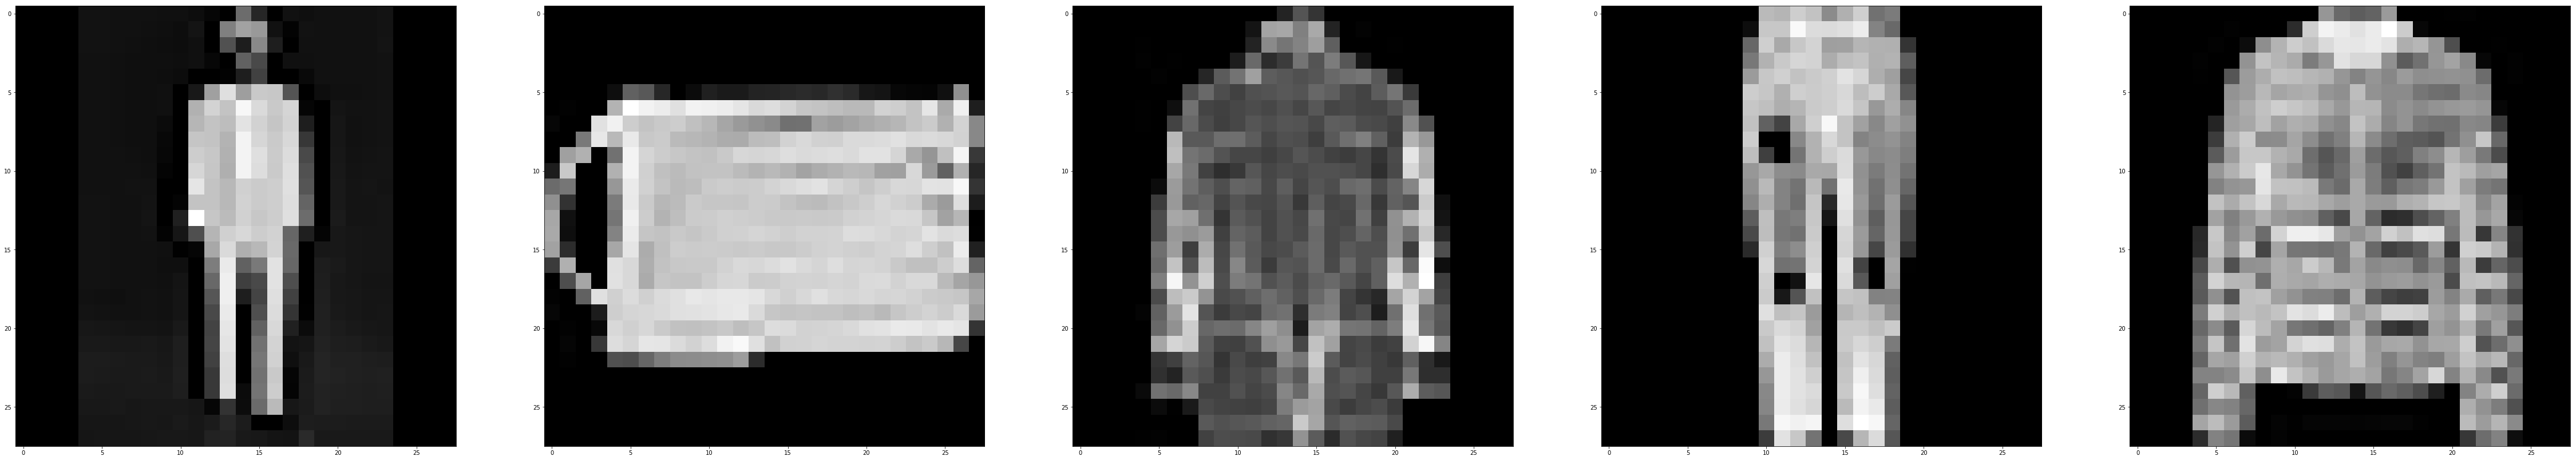

In [25]:
n = np.random.randint(0,len(x_test)-5)

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(x_test[a, :, :, 0].reshape(28, 28))
    

### Noisy images

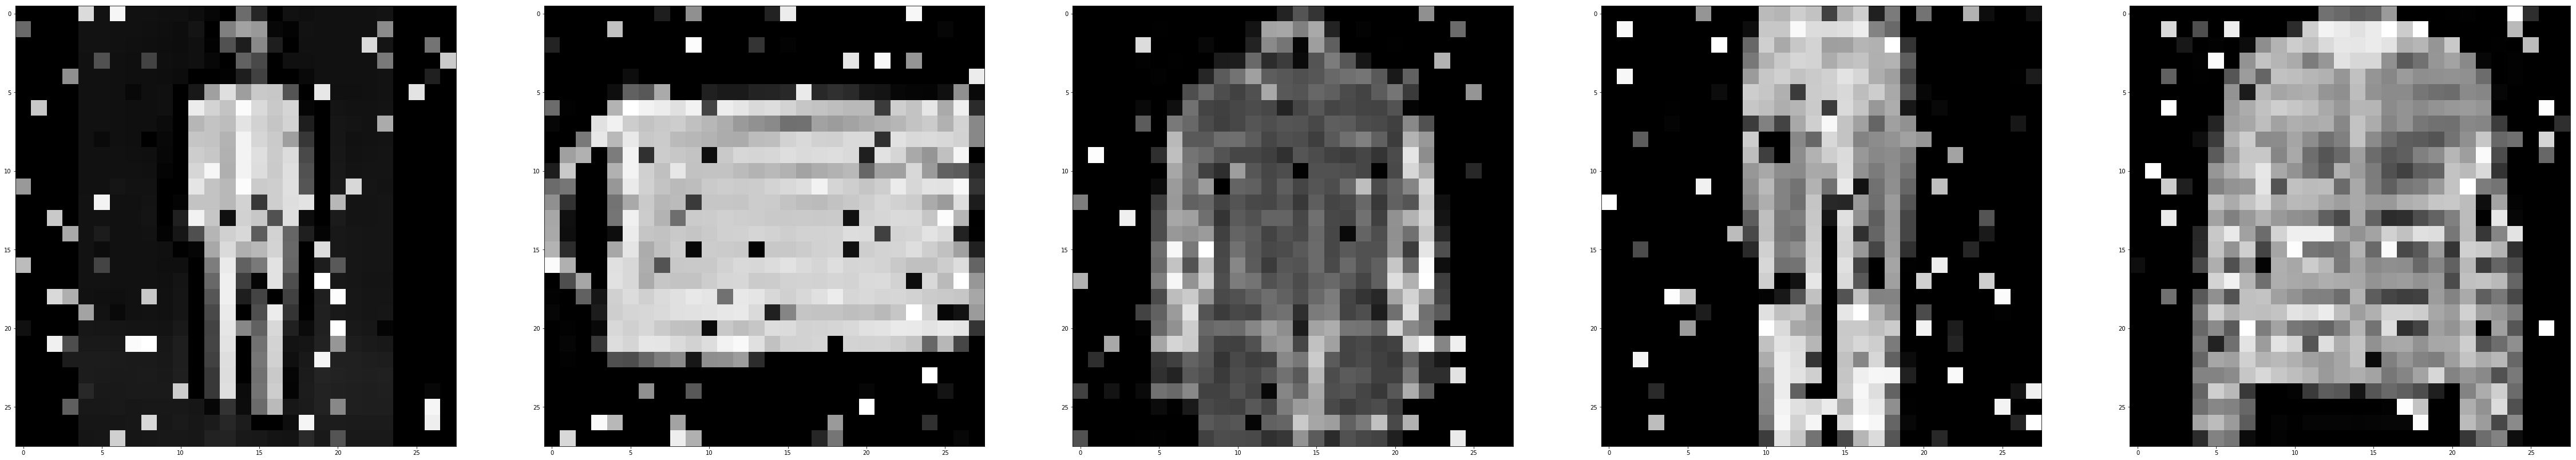

In [26]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x_n[a, :, :, 0].reshape(28, 28))

### Images after denoising 

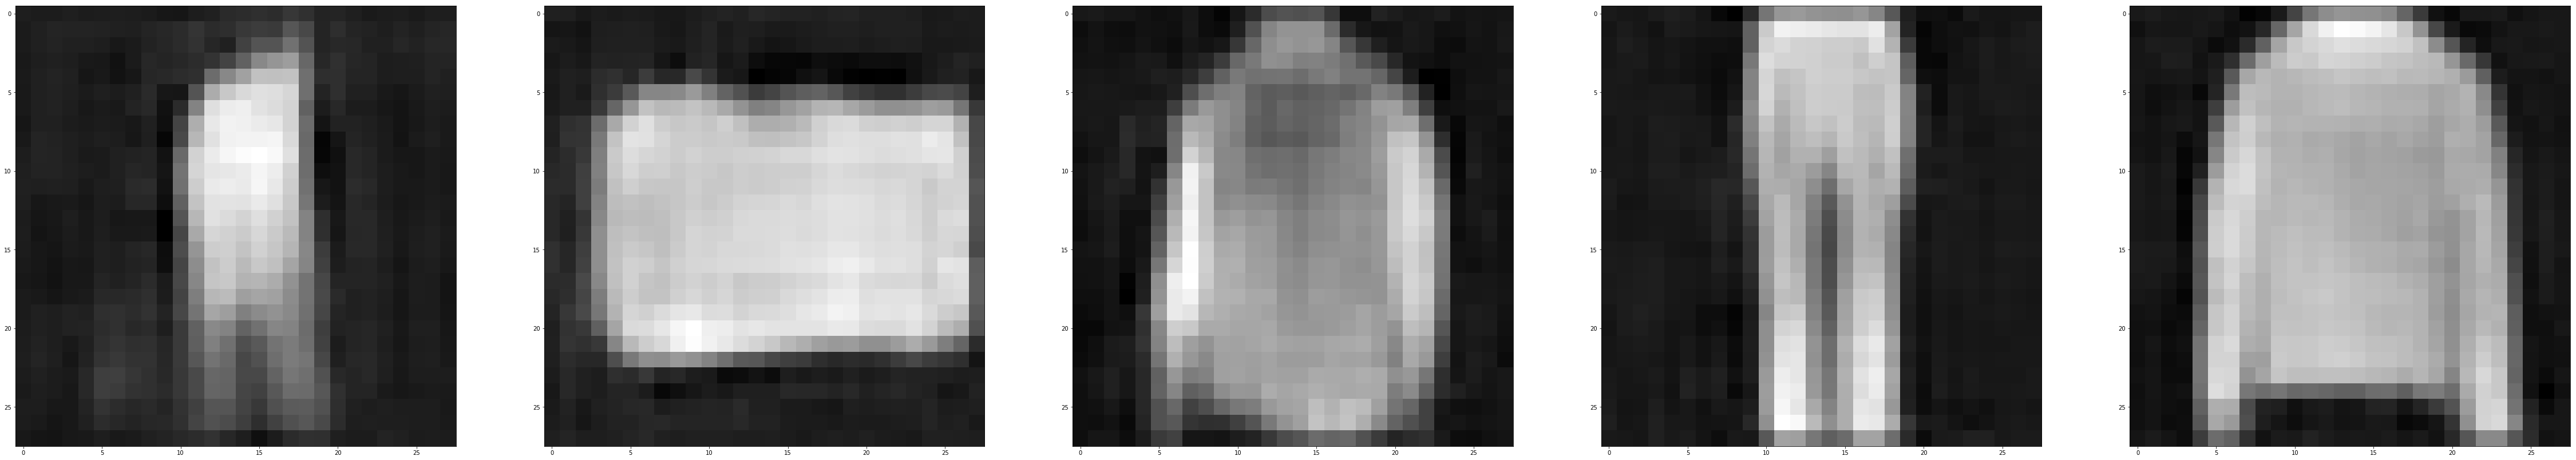

In [27]:
preds = model.predict(val_x_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

### Show intermediate results

In [28]:
# compile the model
model_2 = Model(input_layer, latent_view)
model_2.compile(optimizer='adam', loss='mse')

In [29]:
preds = model_2.predict(val_x_n[n:n+5])
preds.shape

(5, 4, 4, 16)

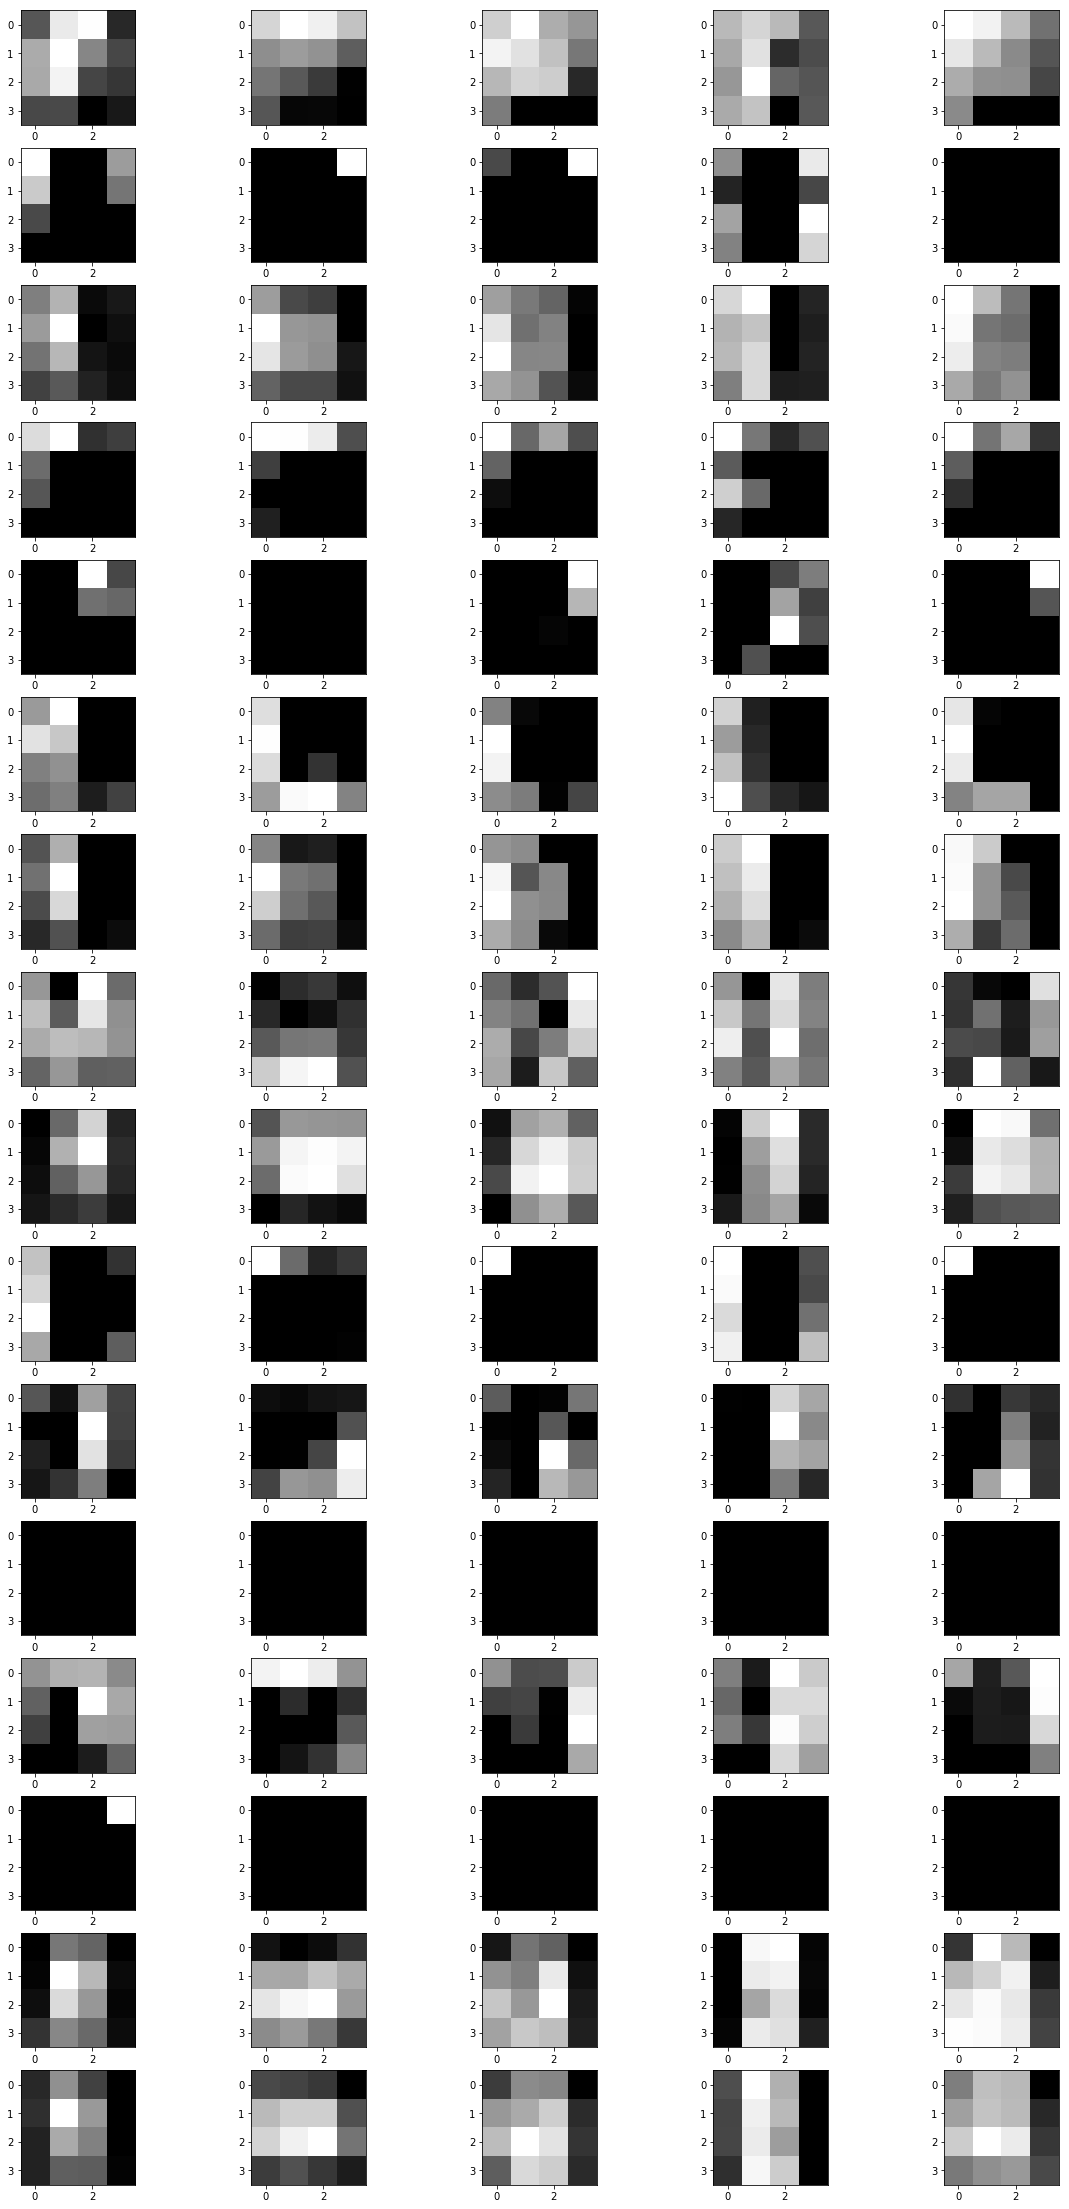

In [30]:
f, ax = plt.subplots(16,5)
ax = ax.ravel()
f.set_size_inches(20, 40)
for j in range(16):
    for i,a in enumerate(range(n,n+5)):
        ax[j*5 + i].imshow(preds[i, :, :, j])
plt.show()